In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BertConfig, BertModel

import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [ ]:
torch.__version__
# transformers.__version__

'2.5.0+cu124'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.legacy.model_stuff import (
    fix_all_seeds,
    train_loop_embedding_layer,
    train_loop_train_test_split_embedding_layer,
    EmbeddingOnlyModel,
)

from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

from text_embeddings_src.legacy.embeddings import generate_embeddings_embed_layer
from text_embeddings_src.legacy.metrics import knn_accuracy

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-12-09 14:59:05CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

transformers: 4.45.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

text_embeddings_src: 0.0.0
torch              : 2.5.0
transformers       : 4.45.2
pandas             : 2.2.3
matplotlib         : 3.9.2
numpy              : 1.26.4
memory_profiler    : 0.61.0
jupyter_black      : 0.4.0
black              : 24.10.0
distro             : 1.9.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import ICLR dataset

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 271 ms, sys: 72.5 ms, total: 343 ms
Wall time: 329 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# Randomly initialized embedding layer

## Baseline performance

### Embedding layer

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
embedding_only_model_random = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 44.1 ms, sys: 8.72 ms, total: 52.8 ms
Wall time: 183 ms


In [ ]:
# evaluation

embedding_only_model_random.to(device)
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    embedding_only_model_random,
    device,
    batch_size=256,
)

## run knn
knn_accuracies_baseline = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)

  0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
knn_accuracies_baseline

array([0.39923077, 0.03      , 0.01076923])

### Embedding module

In [ ]:
# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings  # .word_embeddings
# new model
embedding_only_model_random = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 29.2 ms, sys: 9.68 ms, total: 38.9 ms
Wall time: 151 ms


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# evaluation

embedding_only_model_random.to(device)
## get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings_embed_layer(
    iclr2024.abstract.to_list(),
    tokenizer,
    embedding_only_model_random,
    device,
    batch_size=256,
)

## run knn
knn_accuracies_baseline = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
)


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
knn_accuracies_baseline

array([0.39461538, 0.03      , 0.04923077])

## Training embedding module

### Run 1
Same as run 8 from the pre-trained embedding module. That means with a lr=5e-1.


In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings  # .word_embeddings
# new model
embedding_only_model_random = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 39.2 ms, sys: 17.9 ms, total: 57.1 ms
Wall time: 281 ms


In [ ]:
# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    embedding_only_model_random,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_1",
    knn_accuracies,
)

print("----------------------------")

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------


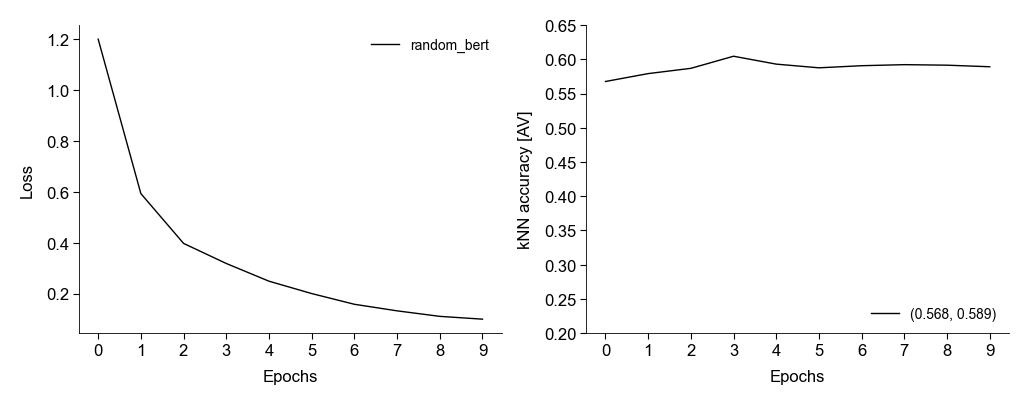

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"

# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_1.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_1.npy"
)

# plot
color = "k"

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label=model_name,
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_random_run_1_v1.png"
)

## Training embedding layer

### Run 2
Same as run 10 from the pre-trained embedding layer

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_2", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_2",
    knn_accuracies,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 15min 21s, sys: 6min 23s, total: 21min 45s
Wall time: 4min 53s


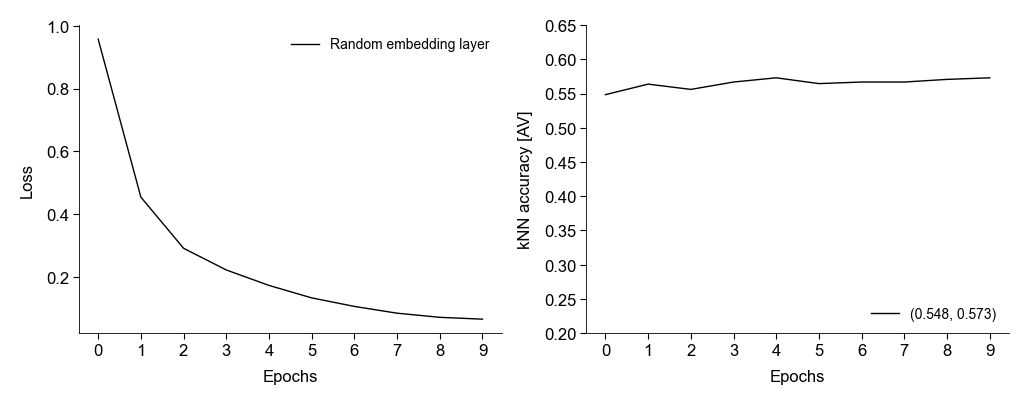

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"


# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_2.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_2.npy"
)

# plot
color = "k"  

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)

axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

fig.savefig(
    figures_path
    / "loss_and_knn_accuracy_training_embedding_layer_random_run_2_v1.png"
)

### Run 3 
Same as run 2 above but evaluating knn acc using cosine distances

#### 1 epoch

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)


# training
(
    losses,
    knn_accuracies,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=1,
    lr=5e-1,
    return_embeddings=True,
)


knn_accuracies_cosine = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
print(knn_accuracies)
print(knn_accuracies_cosine)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_3", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_3",
    knn_accuracies,
)
np.save(
    variables_path / saving_path / "knn_accuracies_cosine_run_3",
    knn_accuracies_cosine,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[array([0.55615385, 0.03      , 0.01076923])]
[0.58307692 0.04769231 0.04615385]
----------------------------
CPU times: user 3min, sys: 2min 8s, total: 5min 9s
Wall time: 43.6 s


#### 10 epoch

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)


# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract,
    tokenizer,
    device,
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)


# training
(
    losses,
    knn_accuracies,
    embedding_cls,
    embedding_sep,
    embedding_av,
) = train_loop_embedding_layer(
    model,
    training_loader,
    device,
    iclr2024.abstract.to_list(),
    tokenizer,
    (labels_iclr != "unlabeled"),
    labels_acc=labels_iclr[labels_iclr != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=5e-1,
    return_embeddings=True,
)


knn_accuracies_cosine = knn_accuracy(
    [
        embedding_av[labels_iclr != "unlabeled"],
        embedding_cls[labels_iclr != "unlabeled"],
        embedding_sep[labels_iclr != "unlabeled"],
    ],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
print(knn_accuracies)
print(knn_accuracies_cosine)

# save
saving_path = Path("embeddings_random_bert") / Path(
    "updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_run_3_10_epochs", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_run_3_10_epochs",
    knn_accuracies,
)
np.save(
    variables_path / saving_path / "knn_accuracies_cosine_run_3_10_epochs",
    knn_accuracies_cosine,
)

print("----------------------------")

Running on device: cuda


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[array([0.53538462, 0.03      , 0.01076923]), array([0.56307692, 0.03      , 0.01076923]), array([0.55769231, 0.03      , 0.01076923]), array([0.57692308, 0.03      , 0.01076923]), array([0.57538462, 0.03      , 0.01076923]), array([0.57384615, 0.03      , 0.01076923]), array([0.56538462, 0.03      , 0.01076923]), array([0.57      , 0.03      , 0.01076923]), array([0.57615385, 0.03      , 0.01076923]), array([0.57230769, 0.03      , 0.01076923])]
[0.58153846 0.04769231 0.04615385]
----------------------------
CPU times: user 15min 11s, sys: 7min 59s, total: 23min 10s
Wall time: 4min 42s


<matplotlib.legend.Legend>

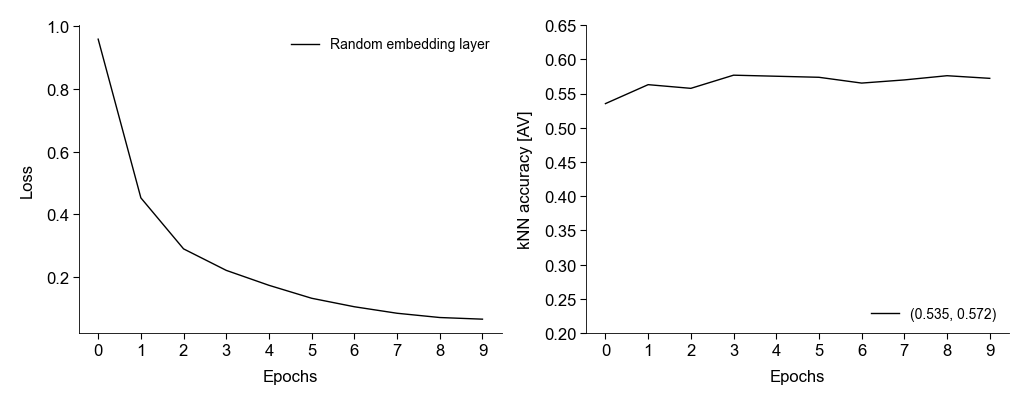

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")
model_name = "random_bert"


# load things
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset/embedding_layer_experiment"
)
losses = np.load(variables_path / saving_path / "losses_run_3_10_epochs.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_run_3_10_epochs.npy"
)


# plot
color = "k"  

axs[0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label="Random embedding layer",
    color=color,
)
axs[0].set_xticks(np.arange(n_epochs))
# axs[0].set_ylim(top=0.05)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
axs[1].set_xticks(np.arange(n_epochs))
axs[1].set_ylim(0.2, 0.65)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("kNN accuracy [AV]")
axs[1].legend(loc="lower right")

### Training only on train set
same as run 3 but with euclidean distances for knn accuracy and train/test split, 
10 epochs

In [ ]:
from transformers import BertConfig, BertModel

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig()

# Initializing a model (with random weights) from the bert-base-uncased style configuration
model_random = BertModel(configuration)

# Accessing the model configuration
configuration = model_random.config

In [ ]:
%%time

# fix random seeds
fix_all_seeds()

# set up model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Extract the embedding layer
embedding_layer = model_random.embeddings.word_embeddings
# new model
model = EmbeddingOnlyModel(embedding_layer)

Running on device: cuda
CPU times: user 48.1 ms, sys: 5.02 ms, total: 53.1 ms
Wall time: 177 ms


In [ ]:
%%time
# data
# split the data in train and test before dataset and loader
random_state = np.random.seed(42)
(
    abstracts_iclr_train,
    abstracts_iclr_test,
    labels_iclr_train,
    labels_iclr_test,
) = train_test_split(
    iclr2024.abstract,
    labels_iclr,
    test_size=0.1,
    random_state=random_state,
)

# only do a dataset and loader from the training set
training_dataset = MultOverlappingSentencesPairDataset(
    abstracts_iclr_train, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(42)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

# training
losses, knn_accuracies = train_loop_train_test_split_embedding_layer(
    model,
    training_loader,
    device,
    tokenizer,
    abstracts_iclr_train[labels_iclr_train != "unlabeled"].to_list(),
    abstracts_iclr_test[labels_iclr_test != "unlabeled"].to_list(),
    labels_iclr_train[labels_iclr_train != "unlabeled"],
    labels_iclr_test[labels_iclr_test != "unlabeled"],
    optimized_rep="av",
    n_epochs=10,
    lr=2e-5,
)

# save
saving_path = Path("embeddings_random_bert") / Path(
    f"updated_dataset/embedding_layer_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True, parents=True)

np.save(
    variables_path / saving_path / "losses_run3_10_epochs_train_test_split",
    losses,
)
np.save(
    variables_path
    / saving_path
    / "knn_accuracies_run3_10_epochs_train_test_split",
    knn_accuracies,
)


print("----------------------------")

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/6 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 3min 43s, sys: 40.7 s, total: 4min 24s
Wall time: 2min 5s


In [ ]:
print(knn_accuracies)

[0.4946727549467275]
